# Import Modules

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt


2024-05-14 03:31:07.641870: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 03:31:07.693144: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 03:31:08.003213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 03:31:09.549501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Generate FASTA File

In [2]:
def prepare_fasta_file(input_file, output_file):
    sequences = []
    sequence_names = []
    current_seq = []
    seq_id = 1

    with open(input_file, 'r') as file:
        for line in file:
            line = line.strip()
            if line == '<>':
                if current_seq:
                    sequence_names.append(f"seq_{seq_id}")
                    sequences.append(''.join(current_seq))
                    current_seq = []
                    seq_id += 1
                continue
            parts = line.split()
            if len(parts) == 2:
                current_seq.append(parts[0])

    write_fasta(output_file, sequences, sequence_names)

def write_fasta(filepath, sequences, sequence_names):
    with open(filepath, 'w') as file:
        for name, seq in zip(sequence_names, sequences):
            file.write(f'>{name}\n')
            file.write(f'{seq}\n')

train_fasta = 'profiling/train_sequences.fasta'
test_fasta = 'profiling/test_sequences.fasta'

train_path = 'Q_and_s_data/protein-secondary-structure.train.txt'
test_path = 'Q_and_s_data/protein-secondary-structure.test.txt'

prepare_fasta_file(train_path, train_fasta)
prepare_fasta_file(test_path, test_fasta)

# Generate PSSM Profiles

In [3]:
# make database from FASTA file
!makeblastdb -in profiling/train_sequences.fasta -dbtype prot -out profiling/train_db

# Run PSI-BLAST using your training database to create PSSMs
!psiblast -query profiling/train_sequences.fasta -db profiling/train_db -num_iterations 3 -out_pssm profiling/train.pssm -out_ascii_pssm profiling/train_ascii.pssm
!psiblast -query profiling/test_sequences.fasta -db profiling/train_db -num_iterations 3 -out_pssm profiling/test.pssm -out_ascii_pssm profiling/test_ascii.pssm



Building a new DB, current time: 05/14/2024 03:31:12
New DB name:   /mnt/c/github/Computational-Biology-Coursework/profiling/train_db
New DB title:  profiling/train_sequences.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 110 sequences in 0.0268059 seconds.


PSIBLAST 2.12.0+


Reference: Stephen F. Altschul, Thomas L. Madden, Alejandro A.
Schaffer, Jinghui Zhang, Zheng Zhang, Webb Miller, and David J.
Lipman (1997), "Gapped BLAST and PSI-BLAST: a new generation of
protein database search programs", Nucleic Acids Res. 25:3389-3402.


Reference for compositional score matrix adjustment: Stephen F.
Altschul, John C. Wootton, E. Michael Gertz, Richa Agarwala,
Aleksandr Morgulis, Alejandro A. Schaffer, and Yi-Kuo Yu (2005)
"Protein database searches using compositionally adjusted
substitution matrices", FEBS J. 272:5101-5109.


Reference for composition-based statistics starting in round 2:
Alejandro A. Schaffer, L. Aravind, T

# Import and Prepare Data with PSSMs 

In [9]:
def read_pssm_file(pssm_filepath):
    with open(pssm_filepath, 'r') as file:
        lines = file.readlines()
    
    pssm_data = []
    recording = False  # Flag to indicate if we are reading the matrix part
    for line in lines:
        if line.startswith('#') or line.startswith('Last position-specific scoring matrix'):
            continue
        parts = line.strip().split()
        if not parts:  # Skip empty lines
            continue
        if len(parts) == 1 and parts[0].startswith('Lambda'):  # Stop when reaching the end of the matrix
            break
        if len(parts) > 22 and parts[0].isdigit():
            try:
                scores = [float(x) for x in parts[2:22]]
                pssm_data.append(scores)
            except ValueError:
                print(f"Skipping line due to value error: {line}")
                continue
    
    return np.array(pssm_data)

train_pssm = 'profiling/train_ascii.pssm'
test_pssm = 'profiling/test_ascii.pssm'


train_pssm_data = read_pssm_file(train_pssm)
test_pssm_data = read_pssm_file(test_pssm)

print(f"Train PSSM Data Shape: {train_pssm_data.shape}")
print(f"Test PSSM Data Shape: {test_pssm_data.shape}")
print(f"Train PSSM Data (first 5 rows):\n {train_pssm_data[:5]}")
print(f"Test PSSM Data (first 5 rows):\n {test_pssm_data[:5]}")

Train PSSM Data Shape: (374, 20)
Test PSSM Data Shape: (339, 20)
Train PSSM Data (first 5 rows):
 [[ 1. -1.  1.  0. -1.  0.  0.  0. -1. -2. -2.  0. -2. -2. -1.  4.  1. -3.
  -2. -2.]
 [ 0. -1.  0. -1. -1. -1. -1. -2. -2. -1. -1. -1. -1. -2. -1.  1.  5. -2.
  -2.  0.]
 [ 4. -1. -2. -2.  0. -1. -1.  0. -2. -1. -1. -1. -1. -2. -1.  1.  0. -3.
  -2.  0.]
 [ 0. -2.  0. -1. -3. -2. -2.  6. -2. -4. -4. -2. -3. -3. -2.  0. -2. -3.
  -3. -3.]
 [-1.  2.  0. -1. -3.  1.  1. -2. -1. -3. -2.  5. -1. -3. -1.  0. -1. -3.
  -2. -2.]]
Test PSSM Data (first 5 rows):
 [[-2.  0.  1. -1. -3.  0.  0. -2.  8. -3. -3. -1. -2. -1. -2. -1. -2. -3.
   2. -3.]
 [-1. -2. -2. -2. -3. -1. -1. -2. -2. -3. -3. -1. -3. -4.  8. -1. -1. -4.
  -3. -3.]
 [ 0. -1.  0. -1. -1. -1. -1. -2. -2. -1. -1. -1. -1. -2. -1.  1.  5. -3.
  -2.  0.]
 [-2. -3. -3. -4. -3. -3. -3. -3. -1.  0.  0. -3.  0.  7. -4. -3. -2.  1.
   3. -1.]
 [-2.  0.  6.  1. -3.  0.  0.  0.  1. -3. -4.  0. -2. -3. -2.  1.  0. -4.
  -2. -3.]]


In [18]:
def one_hot_encode(seq, vocab):
    """One-hot encode a sequence based on a given vocabulary."""
    one_hot = np.zeros((len(seq), len(vocab)), dtype=np.float32)
    for i, char in enumerate(seq):
        if char in vocab:
            one_hot[i, vocab.index(char)] = 1.0
    return one_hot

# Read PSSM files
def read_pssm_file(pssm_filepath):
    with open(pssm_filepath, 'r') as file:
        lines = file.readlines()

    pssm_data = []
    for line in lines:
        if line.startswith('#') or line.startswith('Last position-specific scoring matrix'):
            continue
        parts = line.strip().split()
        if len(parts) < 22:
            continue
        try:
            scores = [float(x) for x in parts[2:22]]
            pssm_data.append(scores)
        except ValueError:
            continue
    
    return np.array(pssm_data)

def prepare_data_with_pssm(seq_filepath, pssm_filepath, window_size=13):
    sequences = []
    structures = []
    current_seq = []
    current_struct = []
    processing_sequence = False
    pssm_data = read_pssm_file(pssm_filepath)

    with open(seq_filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if line == '<>':
                if processing_sequence:
                    if current_seq and current_struct:
                        seq_encoded = one_hot_encode(current_seq, aa_vocab)
                        struct_encoded = one_hot_encode(current_struct, structure_vocab)
                        for i in range(len(seq_encoded) - window_size + 1):
                            window = seq_encoded[i:i + window_size]
                            if i + window_size > len(pssm_data):
                                continue  # Skip if PSSM data is not long enough
                            pssm_window = pssm_data[i:i + window_size]
                            if window.shape[0] != pssm_window.shape[0]:
                                print(f"Skipping window due to length mismatch: seq {window.shape[0]}, pssm {pssm_window.shape[0]}")
                                continue
                            combined_input = np.concatenate((window, pssm_window), axis=1)
                            label = struct_encoded[i + window_size // 2]
                            sequences.append(combined_input)
                            structures.append(label)
                    current_seq = []
                    current_struct = []
                processing_sequence = not processing_sequence
                continue

            if processing_sequence:
                parts = line.split()
                if len(parts) != 2:
                    continue
                current_seq.append(parts[0])
                current_struct.append(parts[1])

    return np.array(sequences), np.array(structures)

# Define your vocabularies
aa_vocab = 'ACDEFGHIKLMNPQRSTVWY_'  # 20 amino acids + 1 for gap/unknown
structure_vocab = 'he_'  # h for helix, e for sheet, _ for coil

# Paths to the data files and PSSM files
train_path = 'Q_and_s_data/protein-secondary-structure.train.txt'
test_path = 'Q_and_s_data/protein-secondary-structure.test.txt'
train_pssm = 'profiling/train_ascii.pssm'
test_pssm = 'profiling/test_ascii.pssm'

# Prepare the data with PSSM profiles
x_train, y_train = prepare_data_with_pssm(train_path, train_pssm)
x_test, y_test = prepare_data_with_pssm(test_path, test_pssm)

In [19]:
def verify_pssm_file(pssm_filepath, expected_length):
    pssm_data = read_pssm_file(pssm_filepath)
    if len(pssm_data) != expected_length:
        print(f"Warning: PSSM file {pssm_filepath} length mismatch. Expected {expected_length}, got {len(pssm_data)}")
    else:
        print(f"PSSM file {pssm_filepath} is verified with expected length {expected_length}")

# Verify train and test PSSM files
train_seq_length = sum(1 for line in open(train_path) if line.strip() and not line.startswith('<>'))
test_seq_length = sum(1 for line in open(test_path) if line.strip() and not line.startswith('<>'))

verify_pssm_file(train_pssm, train_seq_length)
verify_pssm_file(test_pssm, test_seq_length)

In [12]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(8047, 13, 41) (8047, 3)
(1592, 13, 41) (1592, 3)


# Model Design and Training

In [23]:
# Define the model architecture
#model = Sequential([
#    Flatten(input_shape=(13, 21 + 20)),  # 21 for one-hot encoding + 20 for PSSM
#    Dense(40, activation='sigmoid'),
#    Dense(3, activation='linear')
#])
#
## Compile the model
#model.compile(optimizer='sgd', 
#              loss='mean_squared_error', 
#              metrics=['accuracy'])
#

model = Sequential([
    Flatten(input_shape=(13, 21 + 20)),  # 21 for one-hot encoding + 20 for PSSM
    Dense(40, activation='sigmoid'),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Predict the final results
final_pred = model.predict(x_test)

Epoch 1/100


/home/tom/miniconda3/envs/bio-wsl/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4815 - loss: 1.0655 - val_accuracy: 0.5521 - val_loss: 0.9989
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5465 - loss: 1.0064 - val_accuracy: 0.5584 - val_loss: 0.9947
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5318 - loss: 1.0114 - val_accuracy: 0.5559 - val_loss: 0.9967
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5323 - loss: 1.0075 - val_accuracy: 0.5565 - val_loss: 0.9952
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5409 - loss: 0.9953 - val_accuracy: 0.5609 - val_loss: 0.9949
Epoch 6/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5369 - loss: 0.9916 - val_accuracy: 0.5628 - val_loss: 0.9942
Epoch 7/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5282 - loss: 0.9973 - val_accuracy: 0.5616 - val_loss: 0.9947
Epoch 8/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5341 - loss: 0.9868 - val_accuracy: 0.5565

KeyboardInterrupt: 

# Evaluate

In [22]:
# Convert probabilities to class labels
y_true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(final_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, predicted_labels)
print("Q3 Score:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Calculate Matthews Correlation Coefficient for each class
# Calculate MCC for each class
mcc_scores = []
for i in range(3):  # 3 classes: Helix, Sheet, Coil
    # Create binary arrays for each class
    true_binary = (y_true_labels == i).astype(int)
    pred_binary = (predicted_labels == i).astype(int)

    # Calculate MCC and handle cases with constant predictions
    if np.unique(true_binary).size > 1 and np.unique(pred_binary).size > 1:
        mcc = matthews_corrcoef(true_binary, pred_binary)
    else:
        mcc = 0  # Not enough data to compute MCC or one class constant
    mcc_scores.append(mcc)
    print(f"MCC for class {['Helix', 'Sheet', 'Coil'][i]}: {mcc:.3f}")

Q3 Score: 0.6048994974874372
Confusion Matrix:
 [[143  15 249]
 [ 65  43 186]
 [ 96  18 777]]
MCC for class Helix: 0.239
MCC for class Sheet: 0.220
MCC for class Coil: 0.293


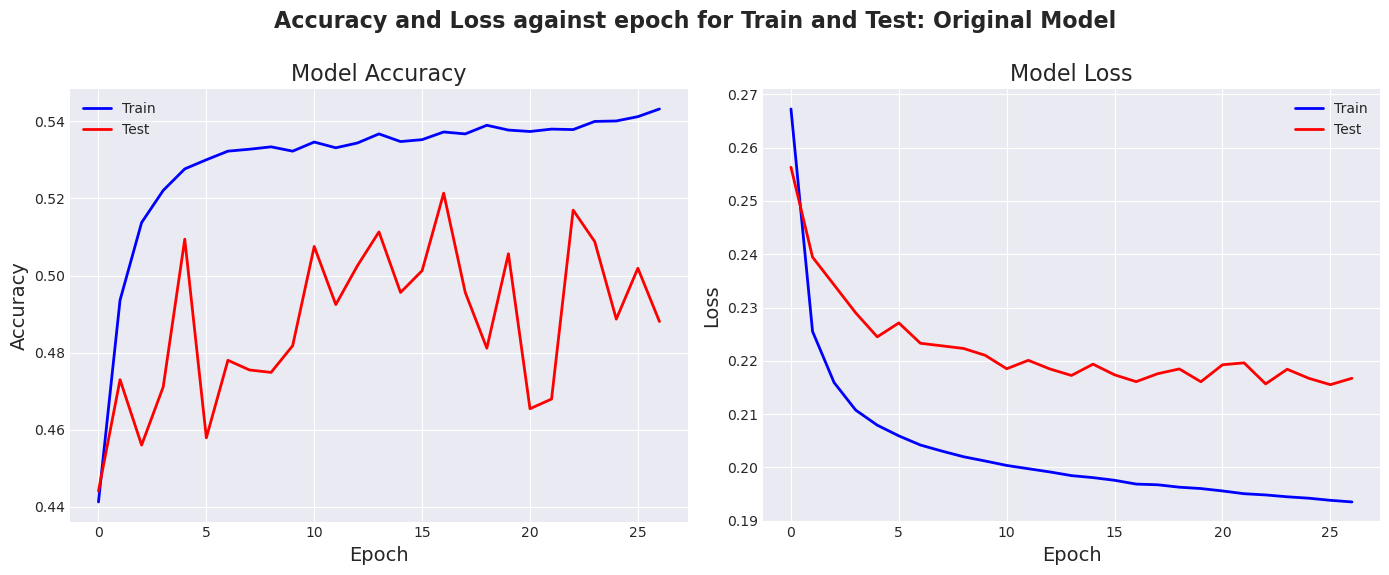

In [15]:
def plot_history(history):
 # Set the style
    plt.style.use('seaborn-v0_8-dark')  # Using a clean and professional style

    # Create figure and set size
    plt.figure(figsize=(14, 6))
    plt.suptitle('Accuracy and Loss against epoch for Train and Test: Original Model', fontsize=16, fontweight='bold', y=0.95)

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], linestyle='-', color='blue', linewidth=2)
    plt.plot(history.history['val_accuracy'], linestyle='-', color='red', linewidth=2)
    plt.title('Model Accuracy', fontsize=16)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.grid(True)

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], linestyle='-', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], linestyle='-', color='red', linewidth=2)
    plt.title('Model Loss', fontsize=16)
    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.grid(True)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the bottom rect to reduce the space
    
    # save the plot
    #plt.savefig('figures/original_model_accuracy_loss.png',dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

plot_history(history)  # Plot for the first model